In [1]:
from zlib import crc32
import numpy as np

if __name__=='__main__':
    mail = input('Enter phystech e-mail\n') 
    seed = crc32(mail.strip().encode('utf-8'))%(2**32 - 1)
    rs = np.random.RandomState(seed)
    print('Your tasks are:')
    print(
        '1.{}, 2.{}, 3.{}, 4.{}, 5.{}, 6.{}'.format(
            rs.randint(low=1, high=5), 
            rs.randint(low=1, high=5), 
            rs.randint(low=1, high=5), 
            rs.randint(low=1, high=4), 
            rs.randint(low=1, high=3), 
            rs.randint(low=1, high=3)))
# yurchenko.aa@phystech.edu

Enter phystech e-mail
yurchenko.aa@phystech.edu
Your tasks are:
1.1, 2.3, 3.3, 4.2, 5.2, 6.1


### Задача 1.1
Проверить мощность и консервативность критериев Лиллиефорса, Харке-Бера, Шапиро-Улика для выборок из следующих распределений:
* Нормальное
* Лапласа
* Стьюдента
* Усеченное нормальное распределение (модуль каждого элемента выборки не превосходит 2)

In [86]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import jarque_bera, shapiro

In [93]:
def generator(gtype, iters, sample_size, df, trunc):
    
    if gtype=='norm':
        return [[lilliefors(data)[1],
                 jarque_bera(data)[1],
                 shapiro(data)[1]] for data in [st.norm.rvs(size=sample_size) for _ in range(iters)]]
    
    elif gtype=='laplace':
        return [[lilliefors(data)[1],
                 jarque_bera(data)[1],
                 shapiro(data)[1]] for data in [st.laplace.rvs(size=sample_size) for _ in range(iters)]]
    
    elif gtype=='student':
        return [[lilliefors(data)[1],
                 jarque_bera(data)[1],
                 shapiro(data)[1]] for data in [st.t.rvs(df=df, size=sample_size) for _ in range(iters)]]
    
    elif gtype=='truncnorm':
        return [[lilliefors(data)[1],
                 jarque_bera(data)[1],
                 shapiro(data)[1]] for data in [st.truncnorm.rvs(-trunc, trunc, size=sample_size) for _ in range(iters)]]

In [129]:
def plot_power(gtype, ptype='Power', iters=100, MAX_SAMP=300, step=10, df=1, trunc=2): 

    sample_sizes = range(10, MAX_SAMP+1, step)

    power_lilliefors, power_jarque_bera, power_shapiro = [], [], []

    for sample_size in sample_sizes:

        p_values = generator(gtype, iters, sample_size, df, trunc)

        p_values = np.array(p_values).T
        p_values_lilliefors, p_values_jarque_bera, p_values_shapiro = p_values[0], p_values[1], p_values[2]
        
        power_lilliefors.append(len(p_values_lilliefors[p_values_lilliefors < 0.05]) / iters)
        power_jarque_bera.append(len(p_values_jarque_bera[p_values_jarque_bera < 0.05]) / iters)
        power_shapiro.append(len(p_values_shapiro[p_values_shapiro < 0.05]) / iters)
        

    fig, axes = plt.subplots(figsize=(16, 10))

    axes.plot(sample_sizes, power_lilliefors, sample_sizes, power_jarque_bera, sample_sizes, power_shapiro)
    if ptype == 'Power':
        axes.axhline(y = 1, color='r', linestyle='--')
    else:
        axes.axhline(y = 0.05, color='r', linestyle='--')    
        
    axes.legend(['Lilliefors', 'Jarque-Bera', 'Shapiro'], fontsize = 15)
    axes.set_xlabel('Sample size', fontsize = 15)
    axes.set_ylabel(ptype, fontsize = 15)
    
    if gtype=='student':
        comment = ' with df = ' + str(df)
    elif gtype=='truncnorm':
        comment = ' with trunc = ' + str(trunc)   
    else:
        comment = ''
        
    axes.set_title(ptype + ' from sample size for ' + gtype + ' distribution' + comment, fontsize = 18)

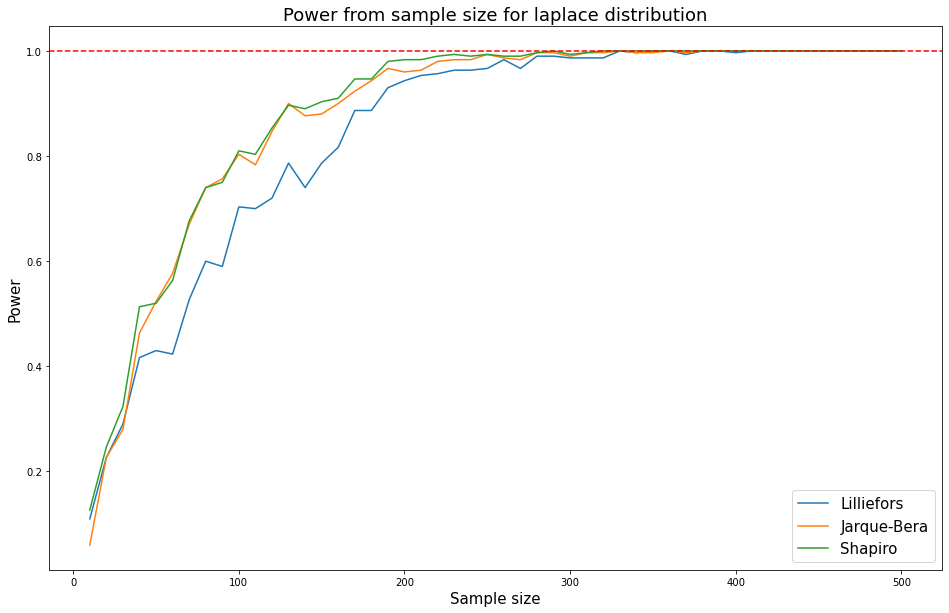

In [132]:
plot_power('laplace', iters=300, MAX_SAMP=500)

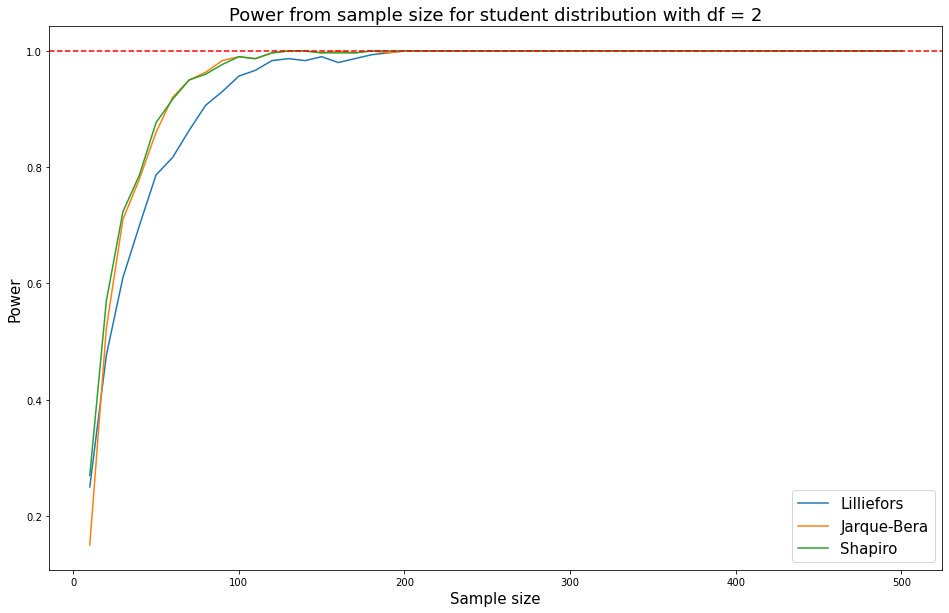

In [130]:
plot_power('student', iters=300, MAX_SAMP=500, df=2)

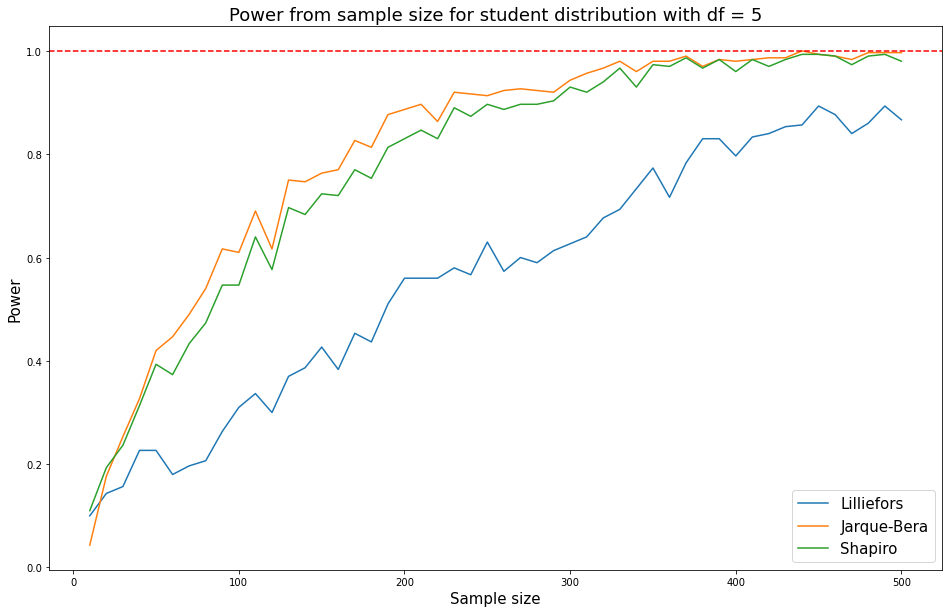

In [133]:
plot_power('student', iters=300, MAX_SAMP=500, df=5)

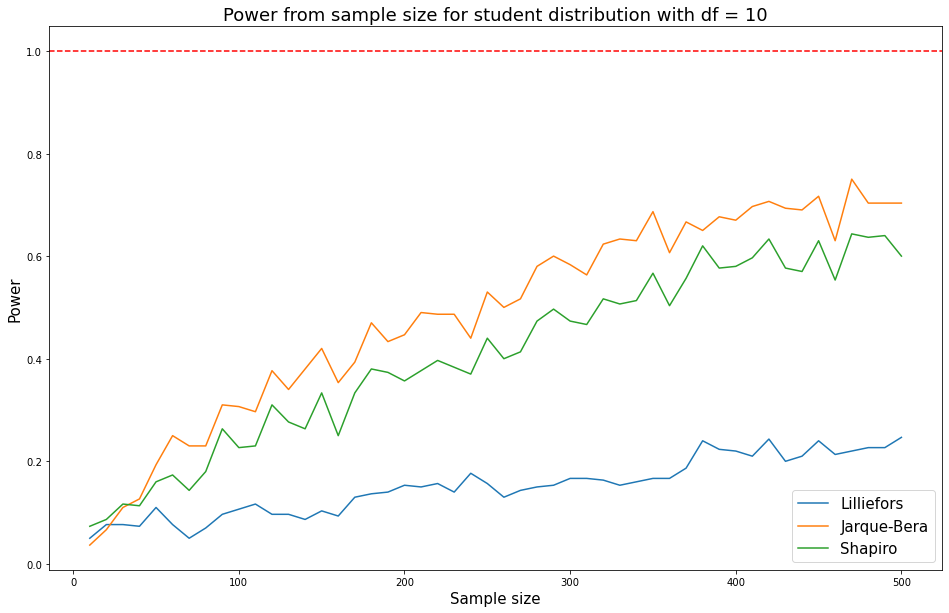

In [134]:
plot_power('student', iters=300, MAX_SAMP=500, df=10)

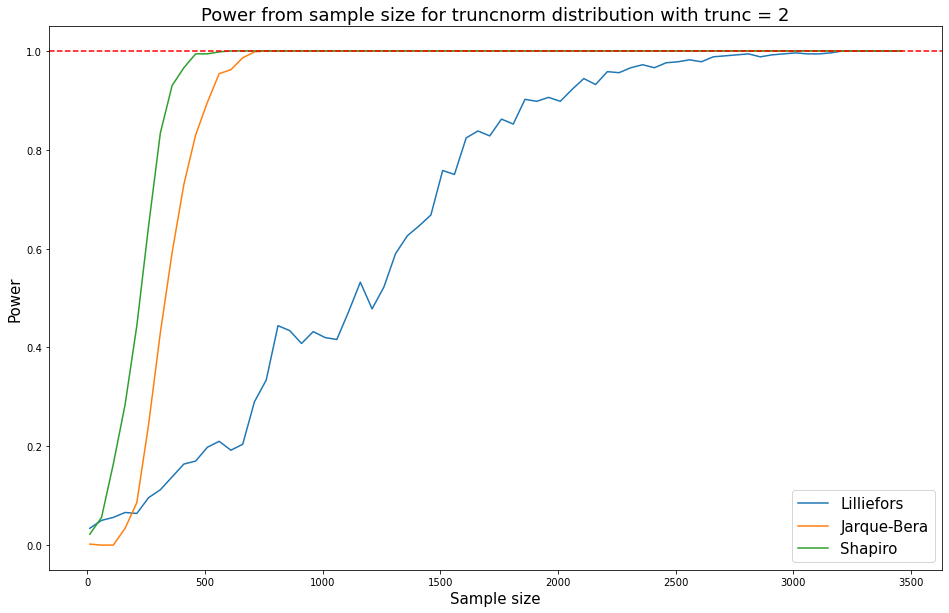

In [131]:
plot_power('truncnorm', iters=500, MAX_SAMP=3500, step=50, trunc=2)

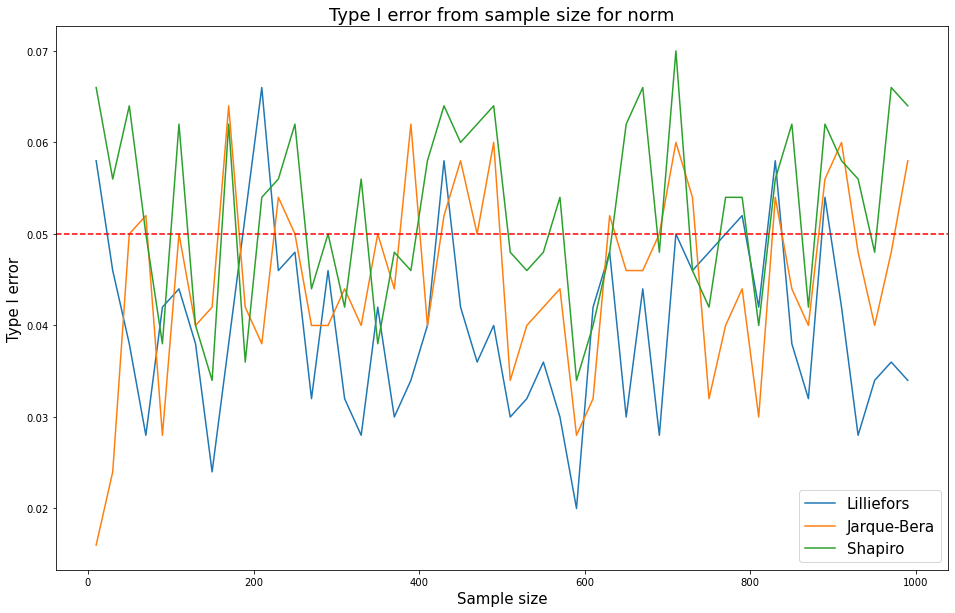

In [125]:
plot_power('norm', ptype='Type I error', iters=500, step=20, MAX_SAMP=1000)

### Задача 2.3
Известно, что электричка "Вашингтон-Петушки" аварийно останавливается раз в несколько дней. Аналитики РЖД проанализировали, сколько дней электричка едет без поломок, и составили выборку: $x = (3, 22, 13, 6, 18, 5, 6, 10, 7, 15)$.

РЖД хочет проверить гипотезу, что дисперсия распределения равна $9$ против правосторонней альтернативы.

Требуется:

Ввести предположение, каким распределением описывается данная выборка.
Записать задачу формально.
* Предложить критерий для оценки дисперсии распределения.
* Проверить гипотезу о значении дисперсии распределения для уровня значимости $\alpha = 0.05$ аналитически.
* Вывести и получить доверительный интервал для значения дисперсии при $\alpha = 0.05$.

Все выкладки должны быть сделаны аналитически, без использования компьютера. (допускается использование компютера для  подстановвки численых значений в финальную формулу)

### Задача 3.3
Предложить метод выбора наиболее важных признаков для логистической регрессии на основе изученных методов прикладной статистики. Осуществить выбор.

In [197]:
import pandas as pd
import numpy as np
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.datasets import load_wine

import statsmodels.api as sm

from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from statsmodels.stats.weightstats  import ttest_ind

In [198]:
wine = load_wine()

featute_cols = wine['feature_names']
X_wine = pd.DataFrame(wine['data'], columns =  featute_cols)
y_wine = wine['target']

df_wine = X_wine
df_wine['target'] = y_wine
df_wine.sample(10).sort_index()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0,0
11,14.12,1.48,2.32,16.8,95.0,2.20,2.43,0.26,1.57,5.00,1.17,2.82,1280.0,0
21,12.93,3.80,2.65,18.6,102.0,2.41,2.41,0.25,1.98,4.50,1.03,3.52,770.0,0
65,12.37,1.21,2.56,18.1,98.0,2.42,2.65,0.37,2.08,4.60,1.19,2.30,678.0,1
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0,1
103,11.82,1.72,1.88,19.5,86.0,2.50,1.64,0.37,1.42,2.06,0.94,2.44,415.0,1
111,12.52,2.43,2.17,21.0,88.0,2.55,2.27,0.26,1.22,2.00,0.90,2.78,325.0,1
127,11.79,2.13,2.78,28.5,92.0,2.13,2.24,0.58,1.76,3.00,0.97,2.44,466.0,1
132,12.81,2.31,2.40,24.0,98.0,1.15,1.09,0.27,0.83,5.70,0.66,1.36,560.0,2
172,14.16,2.51,2.48,20.0,91.0,1.68,0.70,0.44,1.24,9.70,0.62,1.71,660.0,2


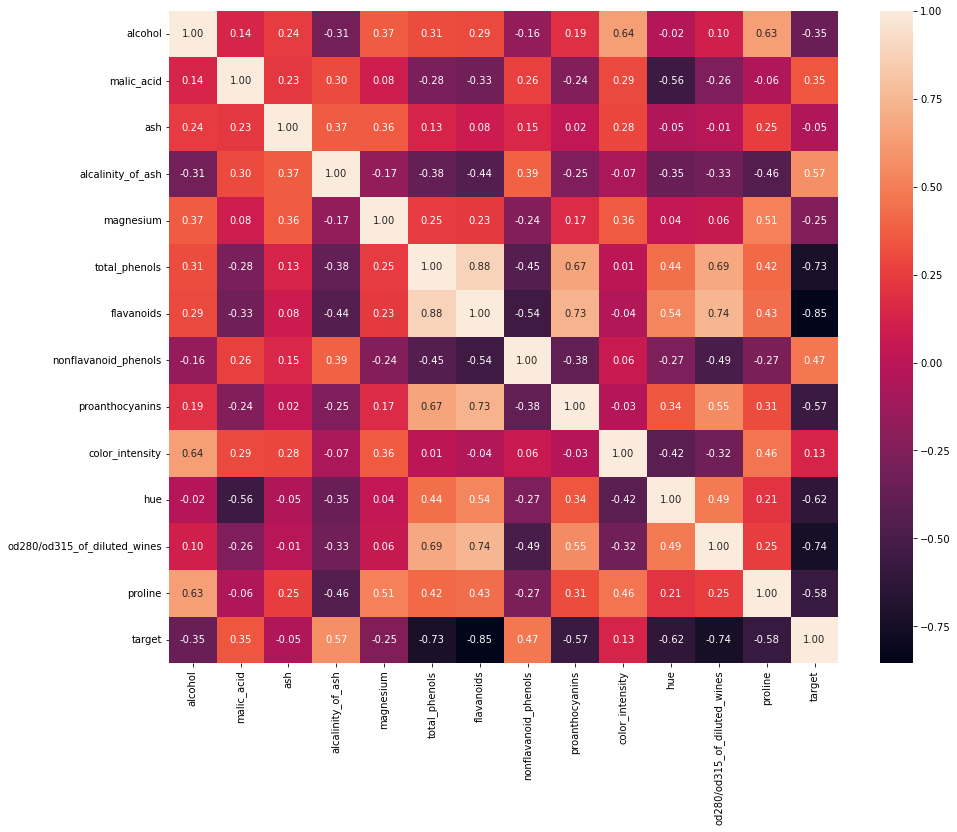

In [199]:
plt.figure(figsize = (15, 12))
_ = sns.heatmap(df_wine.corr(method = 'spearman'), annot=True, fmt = '.2f')

In [200]:
corr_matrix = df_wine.corr(method = 'spearman') \
                     .to_numpy(dtype = 'float64')

corr_matrix[:, -1]

array([-0.35416692,  0.34691327, -0.05398792,  0.56979214, -0.25049819,
       -0.72654365, -0.85490766,  0.47420549, -0.57064758,  0.13117017,
       -0.61657049, -0.7437869 , -0.57638313,  1.        ])

In [201]:
X = df_wine[featute_cols]
y = df_wine['target']

In [202]:
featute_cols

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [203]:
df_wine.shape

(178, 14)

In [204]:
lm = ols('target ~ C(proline)', data=df_wine).fit()
result = sm.stats.anova_lm(lm, typ=1)
result

,df,sum_sq,mean_sq,F,PR(>F)
C(proline),120.0,89.870225,0.748919,2.595037,0.000053
Residual,57.0,16.450000,0.288596,NaN,NaN


In [205]:
from sklearn.feature_selection import f_classif
X = df_wine[featute_cols]
y = df_wine['target']
f_classif(X, y)

(array([135.07762424,  36.94342496,  13.3129012 ,  35.77163741,
         12.42958434,  93.73300962, 233.92587268,  27.57541715,
         30.27138317, 120.66401844, 101.31679539, 189.97232058,
        207.9203739 ]),
 array([3.31950380e-36, 4.12722880e-14, 4.14996797e-06, 9.44447294e-14,
        8.96339544e-06, 2.13767002e-28, 3.59858583e-50, 3.88804090e-11,
        5.12535874e-12, 1.16200802e-33, 5.91766222e-30, 1.39310496e-44,
        5.78316836e-47]))

In [206]:
from sklearn.feature_selection import SelectKBest

fs = SelectKBest(score_func=f_classif, k=4)
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(178, 4)


In [207]:
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
features_df_new

,alcohol,flavanoids,color_intensity,od280/od315_of_diluted_wines,proline
0,14.23,3.06,5.64,3.92,1065.0
1,13.20,2.76,4.38,3.40,1050.0
2,13.16,3.24,5.68,3.17,1185.0
3,14.37,3.49,7.80,3.45,1480.0
4,13.24,2.69,4.32,2.93,735.0
...,...,...,...,...,...
173,13.71,0.61,7.70,1.74,740.0
174,13.40,0.75,7.30,1.56,750.0
175,13.27,0.69,10.20,1.56,835.0
176,13.17,0.68,9.30,1.62,840.0


In [208]:
from sklearn.feature_selection import mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
features_df_new

,flavanoids,color_intensity
0,3.06,5.64
1,2.76,4.38
2,3.24,5.68
3,3.49,7.80
4,2.69,4.32
...,...,...
173,0.61,7.70
174,0.75,7.30
175,0.69,10.20
176,0.68,9.30


### Задача 4.2
Рассмотрим некоторую задачу классификации. Пусть задано качество 4 моделей $a_1, a_2, a_3, a_4$. Качество полученных моделей показано в таблице.

Исследователю требуется выбрать наилучшую модель. Для выбора лучшей модели исследовать требуется попарно сравнить среднее значение качества всех моделей. Может ли исследователь утверждать что какая-то из моделей лучше другой?

Требуется:

* записать задачу формально;
* предложить статистику для решения данной задачи;
* записать нулевое распределение данной статистики;
* записать явно правило принятия решения на основе статистики и нулевого распределения для обеспечения уровня значимости $\alpha = 0.05$;
* проверить гипотезу по записанному критерию, для данных из условия. Противоречат ли они гипотезе?

Все выкладки должны быть сделаны аналитически, без использования компьютера. (допускается использование компютера для подстановвки численых значений в финальную формулу)

In [1]:
import pandas as pd
classifiers = pd.read_csv('classifiers.csv', sep = ',', index_col = 'Номер выборки')
classifiers

,a1,a2,a3,a4
Номер выборки,,,,
1,86,50,93,13
2,85,74,55,35
3,53,92,58,51
4,44,41,56,37
5,2,18,99,26
6,5,68,35,17


In [2]:
classifiers.describe()

,a1,a2,a3,a4
count,6.000000,6.000000,6.000000,6.000000
mean,45.833333,57.166667,66.000000,29.833333
std,36.853313,26.309061,24.754798,14.062954
min,2.000000,18.000000,35.000000,13.000000
25%,14.750000,43.250000,55.250000,19.250000
50%,48.500000,59.000000,57.000000,30.500000
75%,77.000000,72.500000,84.250000,36.500000
max,86.000000,92.000000,99.000000,51.000000


### Задача 5.2

Требуется:

* Отобрать записи, соответствующие странам с минимум 30 респонеднтами в выборке
* Получить сумму zero-crossing по каждой из записей
* Провести ANOVA-анализ по аттрибутам родного языка, пола и возраста для уровня значимости $0.15$. Дискретность признака zero-crossing игнорировать.

In [3]:
import pandas as pd
speakers = pd.read_csv('speakers_all.csv')
speakers.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [4]:
speakers.drop(speakers[speakers['file_missing?'] == True].index, inplace = True)
speakers.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis = 1, inplace = True)

In [5]:
speakers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 32 to 2171
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2140 non-null   float64
 1   age_onset        2140 non-null   float64
 2   birthplace       2136 non-null   object 
 3   filename         2140 non-null   object 
 4   native_language  2140 non-null   object 
 5   sex              2140 non-null   object 
 6   speakerid        2140 non-null   int64  
 7   country          2135 non-null   object 
 8   file_missing?    2140 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 152.6+ KB


In [6]:
query_res = speakers[['speakerid', 'country']].groupby('country', as_index = False) \
                                              .count() \
                                              .query('speakerid >= 30') \
                                              .sort_values('speakerid', ascending = False) 

country_names = list(query_res.country)

In [7]:
speakers = speakers.query("country in @country_names")
speakers

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
50,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False
51,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False
52,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False
53,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False
54,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False
...,...,...,...,...,...,...,...,...,...
2157,23.0,10.0,"zhuzhou, hunan, china",xiang4,xiang,female,2163,china,False
2158,19.0,13.0,"yakutsk, russia",yakut1,yakut,female,1252,russia,False
2161,78.0,6.0,"winnipeg, manitoba, canada",yiddish2,yiddish,female,405,canada,False
2162,52.0,5.0,"brooklyn, new york, usa",yiddish3,yiddish,male,1161,usa,False


In [8]:
import os
rec_dir = 'C:/Users/gds42/OneDrive/Рабочий стол/Stats/Lab1/recordings/'
audio_names = os.listdir(rec_dir)

In [9]:
import IPython.display as ipd  
import librosa
import librosa.display

In [10]:
ipd.Audio(rec_dir + audio_names[3])

In [31]:
%%time
y, sr = librosa.load(rec_dir + audio_names[11], sr = 44100)
librosa.feature.zero_crossing_rate(y).sum()

Wall time: 2.68 s


120.8759765625

In [29]:
%%time
y, sr = librosa.load(rec_dir + audio_names[3], sr = 22050)
librosa.feature.zero_crossing_rate(y).sum()

Wall time: 3.31 s


85.3935546875

In [32]:
zero_crossing = []
for i, audio_file in enumerate(speakers.filename):   
    y, sr = librosa.load(rec_dir + audio_file + '.mp3', sr = 44100)
    zero_crossing.append(librosa.feature.zero_crossing_rate(y).sum())
    if i % 50 == 0:
        print('I have processed {i} files')

I have processed file0
I have processed file50
I have processed file100
I have processed file150
I have processed file200
I have processed file250
I have processed file300
I have processed file350
I have processed file400
I have processed file450
I have processed file500
I have processed file550
I have processed file600
I have processed file650
I have processed file700
I have processed file750
I have processed file800
I have processed file850
I have processed file900
I have processed file950
I have processed file1000


In [33]:
speakers['zero_crossing'] = zero_crossing
speakers

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,zero_crossing
50,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,212.073730
51,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False,177.070312
52,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False,202.801758
53,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False,150.427734
54,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False,255.820801
...,...,...,...,...,...,...,...,...,...,...
2157,23.0,10.0,"zhuzhou, hunan, china",xiang4,xiang,female,2163,china,False,206.517578
2158,19.0,13.0,"yakutsk, russia",yakut1,yakut,female,1252,russia,False,108.870117
2161,78.0,6.0,"winnipeg, manitoba, canada",yiddish2,yiddish,female,405,canada,False,151.707520
2162,52.0,5.0,"brooklyn, new york, usa",yiddish3,yiddish,male,1161,usa,False,104.713867


In [34]:
speakers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 50 to 2170
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              1045 non-null   float64
 1   age_onset        1045 non-null   float64
 2   birthplace       1045 non-null   object 
 3   filename         1045 non-null   object 
 4   native_language  1045 non-null   object 
 5   sex              1045 non-null   object 
 6   speakerid        1045 non-null   int64  
 7   country          1045 non-null   object 
 8   file_missing?    1045 non-null   bool   
 9   zero_crossing    1045 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 82.7+ KB


In [35]:
speakers.to_csv('speakers_with_zero_crossing.csv')

In [37]:
speakers_zc = pd.read_csv('speakers_with_zero_crossing.csv')
speakers_zc

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,zero_crossing
0,50,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,212.073730
1,51,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False,177.070312
2,52,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False,202.801758
3,53,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False,150.427734
4,54,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False,255.820801
...,...,...,...,...,...,...,...,...,...,...,...
1040,2157,23.0,10.0,"zhuzhou, hunan, china",xiang4,xiang,female,2163,china,False,206.517578
1041,2158,19.0,13.0,"yakutsk, russia",yakut1,yakut,female,1252,russia,False,108.870117
1042,2161,78.0,6.0,"winnipeg, manitoba, canada",yiddish2,yiddish,female,405,canada,False,151.707520
1043,2162,52.0,5.0,"brooklyn, new york, usa",yiddish3,yiddish,male,1161,usa,False,104.713867


Провести ANOVA-анализ по аттрибутам родного языка, пола и возраста для уровня значимости  0.15 . Дискретность признака zero-crossing игнорировать.



In [52]:
data = speakers_zc[['native_language', 'sex', 'age', 'zero_crossing']]
data.loc[:, 'age'] = data.loc[:, 'age'].astype(int)
data

C:\Users\gds42\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,native_language,sex,age,zero_crossing
0,amharic,female,20,212.073730
1,amharic,female,29,177.070312
2,amharic,female,24,202.801758
3,amharic,female,26,150.427734
4,amharic,female,28,255.820801
...,...,...,...,...
1040,xiang,female,23,206.517578
1041,yakut,female,19,108.870117
1042,yiddish,female,78,151.707520
1043,yiddish,male,52,104.713867


In [82]:
data.sex.unique(), data.age.unique(), data.native_language.unique()

(array(['female', 'male'], dtype=object),
 array([20, 29, 24, 26, 28, 31, 23, 36, 21, 19, 52, 27, 38, 30, 40, 22, 56,
        18, 25, 32, 39, 50, 57, 43, 54, 34, 61, 33, 41, 46, 42, 35, 60, 71,
        65, 69,  7, 75, 79, 68, 53, 63, 45, 37, 48, 66, 59, 49, 44, 77, 67,
         6, 84, 80, 85, 70, 74, 62, 58, 82, 76, 83, 47, 64, 55, 73, 88, 81,
        90, 86, 51, 78, 72, 97]),
 array(['amharic', 'arabic', 'armenian', 'bai', 'bavarian', 'bengali',
        'cantonese', 'dutch', 'english', 'farsi', 'finnish', 'french',
        'gan', 'gedeo', 'german', 'greek', 'gujarati', 'hadiyya', 'hindi',
        'italian', 'kambaata', 'kannada', 'khmer', 'kikongo', 'konkani',
        'korean', 'malayalam', 'mandarin', 'marathi', 'mongolian', 'naxi',
        'oriya', 'oromo', 'polish', 'portuguese', 'punjabi', 'russian',
        'spanish', 'tagalog', 'taishan', 'tamil', 'tatar', 'telugu',
        'teochew', 'tibetan', 'tigrigna', 'turkish', 'twi', 'urdu',
        'uyghur', 'vlaams', 'wu', 'xiang', 'ya

In [55]:
from zlib import crc32
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st

import statsmodels.api as sm

from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from statsmodels.stats.weightstats  import ttest_ind

In [72]:
lm = ols('zero_crossing ~ C(native_language) * C(sex) + C(age)', data=data).fit()
result = sm.stats.anova_lm(lm, typ=1)
result

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),55.0,1.721213e+06,31294.777384,5.891554,1.172197e-32
C(sex),1.0,5.829783e+04,58297.829849,10.975148,9.605676e-04
C(age),73.0,5.504094e+05,7539.855472,1.419453,1.443879e-02
C(native_language):C(sex),55.0,3.794429e+05,6898.961928,1.298798,7.501289e-02
Residual,892.0,4.738129e+06,5311.803285,NaN,NaN


In [75]:
lm = ols('zero_crossing ~ C(native_language) * C(sex) * C(age)', data=data).fit()
result = sm.stats.anova_lm(lm, typ=3)
result

C:\Users\gds42\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 55, but rank is 38
  warnings.warn('covariance of constraints does not have full '
C:\Users\gds42\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4015, but rank is 380
  warnings.warn('covariance of constraints does not have full '
C:\Users\gds42\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 73, but rank is 62
  warnings.warn('covariance of constraints does not have full '
C:\Users\gds42\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4015, but rank is 245
  warnings.warn('covariance of constraints does no

,sum_sq,df,F,PR(>F)
Intercept,5.717761e+05,1.0,141.539814,3.780297e-29
C(native_language),1.303019e+06,55.0,5.864630,3.310299e-29
C(sex),1.999018e+04,1.0,4.948452,2.652661e-02
C(age),9.163347e+05,73.0,3.107305,6.005711e-14
C(native_language):C(sex),8.777395e+05,55.0,3.950532,4.521115e-13
C(native_language):C(age),3.856681e+07,4015.0,2.377830,1.268537e-20
C(sex):C(age),7.299233e+05,73.0,2.475181,2.927333e-08
C(native_language):C(sex):C(age),3.470195e+07,4015.0,2.139542,1.999909e-13
Residual,2.181429e+06,540.0,NaN,NaN


In [65]:
lm = ols('zero_crossing ~ C(native_language) + C(sex) * C(age)', data=data).fit()
result = sm.stats.anova_lm(lm, typ=1)
result

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),55.0,1.721213e+06,31294.777384,5.839486,4.342586e-32
C(sex),1.0,5.829783e+04,58297.829849,10.878153,1.012860e-03
C(age),73.0,5.504094e+05,7539.855472,1.406908,1.679896e-02
C(sex):C(age),73.0,6.726860e+05,9214.876157,1.719461,2.900555e-04
Residual,863.0,4.624960e+06,5359.166000,NaN,NaN


In [84]:
lm = ols('zero_crossing ~  C(sex) * C(native_language)', data=data).fit()
result = sm.stats.anova_lm(lm, typ=1)
result

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,9.040459e+04,90404.592291,16.343469,5.705637e-05
C(native_language),55.0,1.689106e+06,30711.018067,5.551981,1.550825e-30
C(sex):C(native_language),55.0,7.487128e+05,13612.960573,2.460970,5.056932e-08
Residual,963.0,5.326875e+06,5531.542520,NaN,NaN


In [80]:
lm = ols('zero_crossing ~ C(native_language) + C(age)', data=data.query('sex == "female"')).fit()
result = sm.stats.anova_lm(lm, typ=1)
result

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),42.0,1.258955e+06,29975.111323,6.132140,7.306239e-24
C(age),64.0,5.202502e+05,8128.909524,1.662967,2.005685e-03
Residual,398.0,1.945503e+06,4888.197488,NaN,NaN


### Задача 6.1

Рассмотрим задачу предсказание числа заболевших некоторой болезнью от некоторых экологических анализов (см. файл). Гарантируется, что предсказание описывается линейной моделью.

Так как проведение анализов не является бесплатным, то стоит вопрос о том какие из анализов являются лишними (на уровне значимости $\alpha=0.05$) для предсказания линейной модели.

Требуется:

* Записать задачу формально;
* Провести отбор признаков линейной модели.

Все выкладки должны быть сделаны аналитически, без использования компьютера. (допускается использование компютера для подстановвки численых значений в финальную формулу)

In [16]:
import pandas as pd
sick = pd.read_csv('sick.csv')
sick

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Y
0,-0.5,-0.1,-1.2,-0.6,-1.1,1.4,-1.4,1.2,-0.2,-0.2,0.0
1,1.0,0.4,0.5,-1.1,0.6,-0.1,-0.2,-0.7,-0.5,0.4,1.0
2,0.3,-0.9,0.8,-0.3,-0.2,-1.4,0.4,1.6,1.0,-0.3,3.0
3,-1.1,-0.5,0.5,1.8,0.3,-0.3,-0.1,0.4,1.0,0.3,3.0
4,1.9,0.6,0.4,0.7,-2.9,0.5,-0.9,-1.5,0.9,-3.1,1.0
5,1.8,-0.9,0.9,1.0,0.2,0.3,-0.2,1.7,-1.5,0.2,2.0
6,-0.7,-0.5,1.5,0.2,1.0,-1.2,-0.1,0.1,0.3,-0.7,10.0
7,0.0,-0.8,1.1,0.1,1.0,1.3,0.7,1.0,0.2,1.5,4.0
8,-1.0,-0.4,-0.1,0.6,1.0,1.6,-0.4,-0.3,-0.3,0.8,1.0
9,2.4,2.0,2.0,0.6,1.3,0.3,2.2,2.3,0.7,2.0,5.0
